Importing Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
from scipy.interpolate import interp1d

Filter Simulation Class

In [1]:
import cvxpy as cp
from scipy.linalg import toeplitz

class FilterSimulation():

    def filter(self):
        step_response = np.load('filter_data.npy')
        impulse_response = np.diff(step_response, prepend = 0)
        return impulse_response

    def convolution(self, waveform):
        impulse_response = self.filter()
        filtered_waveform = np.convolve(waveform, impulse_response, mode = 'full')
        return filtered_waveform
    
    def interpolation(self, time, shift, filtered):
        interp_func = interp1d(shift, filtered, kind='linear', bounds_error=False, fill_value="extrapolate")
        filtered_interp = interp_func(time)  # Now same length as time_original
        return filtered_interp
    
    def plotter(self, original, time, filtered, precompensated_unfiltered, precompensated):
        plt.figure()
        plt.plot(time, original, label = 'Original')
        plt.plot(time, filtered, label = 'Filtered')
        plt.plot(time, precompensated_unfiltered, label = 'Precompensated Unfiltered', linestyle = '--')
        plt.plot(time, precompensated, label = 'Precompensated Filtered', linestyle = '--')
        plt.title('Lowpass-Filter Response')
        plt.xlabel('Time in µs')
        plt.ylabel('Voltage')
        plt.grid(True)
        plt.legend()
        plt.show()

    def precompensation(self, waveform, last_index):
        impulse_response = self.filter()
        
        ir_padded = np.pad(impulse_response, (300, len(waveform)),  mode='constant')
        waveform_padded = np.pad(waveform, (300, len(impulse_response)), mode='constant', constant_values = last_index)
        
        G = fft(ir_padded)
        f_t = waveform_padded
        f_w = fft(f_t)

        reg_strength = 1e-3 # L2 regularization strength (prevents extreme values)

        G_magnitude = np.abs(G) # amplitude attenuation
        G_phase = np.angle(G) # phase shift

        # Tikhonov regularization: prevents division by zeros or near-zeros
        regularized_magnitude = G_magnitude / (G_magnitude**2 + reg_strength)
        regularized_G = regularized_magnitude * np.exp(-1j * G_phase)

        h_w = f_w * regularized_G
        h_t = np.real(ifft(h_w))

        return h_t

    def precompensation_sparse(self, desired_output, max_input_length=150, lambda_reg=1e-2):
        """
        L1-regularized deconvolution to find a sparse precompensation waveform.
        
        Parameters:
        - desired_output: the red waveform (target signal after filter)
        - max_input_length: maximum allowed support of the precompensated signal
        - lambda_reg: sparsity regularization strength
        """

        h = self.filter()
        N = max_input_length
        M = len(desired_output)

        # Construct convolution matrix H such that H @ x ≈ y
        first_col = np.r_[h[0], np.zeros(N - 1)]
        first_row = np.r_[h, np.zeros(N - len(h))]
        H = toeplitz(first_col, first_row)[:M, :]

        # Optimization variable: input signal
        x = cp.Variable(N)

        # Desired output signal (truncate or pad to match shape)
        y = desired_output[:M]

        # Solve LASSO: minimize ||Hx - y||^2 + λ * ||x||_1
        objective = cp.Minimize(cp.sum_squares(H @ x - y) + lambda_reg * cp.norm1(x))
        problem = cp.Problem(objective)
        problem.solve()

        return x.value

ModuleNotFoundError: No module named 'cvxpy'

Example Use Cases

In [19]:
CONSTANT_PADDING = 70
time_array = np.array([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1])
beg = np.array([-1, -0.9990133642, -0.9960573507, -0.9911436254, -0.9842915806, -0.9755282581, -0.9648882429, -0.9524135262, -0.93815334, -0.9221639628, -0.9045084972, -0.8852566214, -0.8644843137, -0.842273553, -0.8187119949, -0.7938926261, -0.7679133975, -0.7408768371, -0.7128896458, -0.6840622763, -0.6545084972, -0.6243449436, -0.5936906573, -0.5626666168, -0.5313952598, -0.5, -0.4686047402, -0.4373333832, -0.4063093427, -0.3756550564, -0.3454915028, -0.3159377237, -0.2871103542, -0.2591231629, -0.2320866025, -0.2061073739, -0.1812880051, -0.157726447, -0.1355156863, -0.1147433786, -0.0954915028, -0.0778360372, -0.06184666, -0.0475864738, -0.0351117571, -0.0244717419, -0.0157084194, -0.0088563746, -0.0039426493, -0.0009866358, 0]) + 1
end = np.array([0, -0.0009866358, -0.0039426493, -0.0088563746, -0.0157084194, -0.0244717419, -0.0351117571, -0.0475864738, -0.06184666, -0.0778360372, -0.0954915028, -0.1147433786, -0.1355156863, -0.157726447, -0.1812880051, -0.2061073739, -0.2320866025, -0.2591231629, -0.2871103542, -0.3159377237, -0.3454915028, -0.3756550564, -0.4063093427, -0.4373333832, -0.4686047402, -0.5, -0.5313952598, -0.5626666168, -0.5936906573, -0.6243449436, -0.6545084972, -0.6840622763, -0.7128896458, -0.7408768371, -0.7679133975, -0.7938926261, -0.8187119949, -0.842273553, -0.8644843137, -0.8852566214, -0.9045084972, -0.9221639628, -0.93815334, -0.9524135262, -0.9648882429, -0.9755282581, -0.9842915806, -0.9911436254, -0.9960573507, -0.9990133642, -1]) + 1

original = np.concatenate((beg, end)) # combine beginning and end waveforms into one waveform
first_index = float (original[0])
original_padded = np.pad(original, (CONSTANT_PADDING, 0), mode='constant', constant_values=first_index) # pads beginning to original[0]
last_index = float (original_padded[-1])
subtracted = CONSTANT_PADDING - int(CONSTANT_PADDING/2)
original = np.pad(original_padded, (0, CONSTANT_PADDING - subtracted), mode='constant', constant_values=last_index) # pads beendginning to original[-1]

time = time_array 
dt = time_array[1] - time_array[0]
time = np.arange(len(original)) * dt

filtered = FilterSimulation().convolution(original)
shift_f =  (np.arange(len(filtered)) * dt)
filtered_original = FilterSimulation().interpolation(time, shift_f, filtered)

precompensated = FilterSimulation().precompensation_sparse(original, max_input_length=150, lambda_reg=1e-2)

precompensated_filtered = FilterSimulation().convolution(precompensated)
shift_p = np.arange(len(precompensated_filtered)) * dt
precompensated_original = FilterSimulation().interpolation(time, shift_p, precompensated_filtered)

shift_p_unfiltered = np.arange(len(precompensated)) * dt
precompensated_unfiltered_interp = FilterSimulation().interpolation(time, shift_p_unfiltered, precompensated)

FilterSimulation().plotter(original, time, filtered_original, precompensated_unfiltered_interp, precompensated_original)

AttributeError: 'FilterSimulation' object has no attribute 'precompensation_sparse'

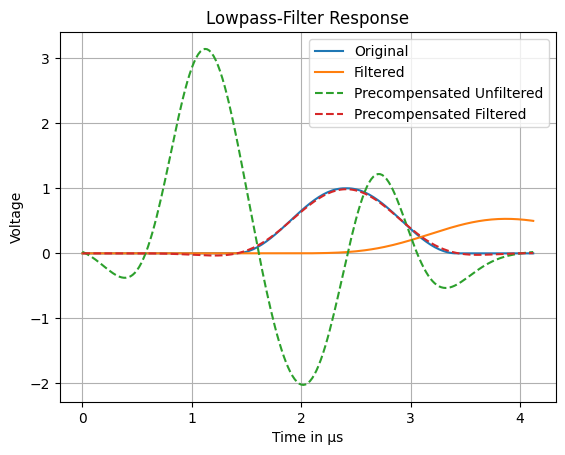

In [15]:
CONSTANT_PADDING = 70
time_array = np.array([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1])
beg = np.array([-1, -0.9990133642, -0.9960573507, -0.9911436254, -0.9842915806, -0.9755282581, -0.9648882429, -0.9524135262, -0.93815334, -0.9221639628, -0.9045084972, -0.8852566214, -0.8644843137, -0.842273553, -0.8187119949, -0.7938926261, -0.7679133975, -0.7408768371, -0.7128896458, -0.6840622763, -0.6545084972, -0.6243449436, -0.5936906573, -0.5626666168, -0.5313952598, -0.5, -0.4686047402, -0.4373333832, -0.4063093427, -0.3756550564, -0.3454915028, -0.3159377237, -0.2871103542, -0.2591231629, -0.2320866025, -0.2061073739, -0.1812880051, -0.157726447, -0.1355156863, -0.1147433786, -0.0954915028, -0.0778360372, -0.06184666, -0.0475864738, -0.0351117571, -0.0244717419, -0.0157084194, -0.0088563746, -0.0039426493, -0.0009866358, 0]) + 1
end = np.array([0, -0.0009866358, -0.0039426493, -0.0088563746, -0.0157084194, -0.0244717419, -0.0351117571, -0.0475864738, -0.06184666, -0.0778360372, -0.0954915028, -0.1147433786, -0.1355156863, -0.157726447, -0.1812880051, -0.2061073739, -0.2320866025, -0.2591231629, -0.2871103542, -0.3159377237, -0.3454915028, -0.3756550564, -0.4063093427, -0.4373333832, -0.4686047402, -0.5, -0.5313952598, -0.5626666168, -0.5936906573, -0.6243449436, -0.6545084972, -0.6840622763, -0.7128896458, -0.7408768371, -0.7679133975, -0.7938926261, -0.8187119949, -0.842273553, -0.8644843137, -0.8852566214, -0.9045084972, -0.9221639628, -0.93815334, -0.9524135262, -0.9648882429, -0.9755282581, -0.9842915806, -0.9911436254, -0.9960573507, -0.9990133642, -1]) + 1

original = np.concatenate((beg, end)) # combine beginning and end waveforms into one waveform
first_index = float (original[0])
original_padded = np.pad(original, (CONSTANT_PADDING, 0), mode='constant', constant_values=first_index) # pads beginning to original[0]
last_index = float (original_padded[-1])
subtracted = CONSTANT_PADDING - int(CONSTANT_PADDING/2)
original = np.pad(original_padded, (0, CONSTANT_PADDING - subtracted), mode='constant', constant_values=last_index) # pads beendginning to original[-1]

time = time_array 
dt = time_array[1] - time_array[0]
time = np.arange(len(original)) * dt

filtered = FilterSimulation().convolution(original)
shift_f =  (np.arange(len(filtered)) * dt)
filtered_original = FilterSimulation().interpolation(time, shift_f, filtered)

precompensated = FilterSimulation().precompensation(original, last_index)

precompensated_filtered = FilterSimulation().convolution(precompensated)
shift_p = np.arange(len(precompensated_filtered)) * dt
precompensated_original = FilterSimulation().interpolation(time, shift_p, precompensated_filtered)

shift_p_unfiltered = np.arange(len(precompensated)) * dt
precompensated_unfiltered_interp = FilterSimulation().interpolation(time, shift_p_unfiltered, precompensated)

FilterSimulation().plotter(original, time, filtered_original, precompensated_unfiltered_interp, precompensated_original)

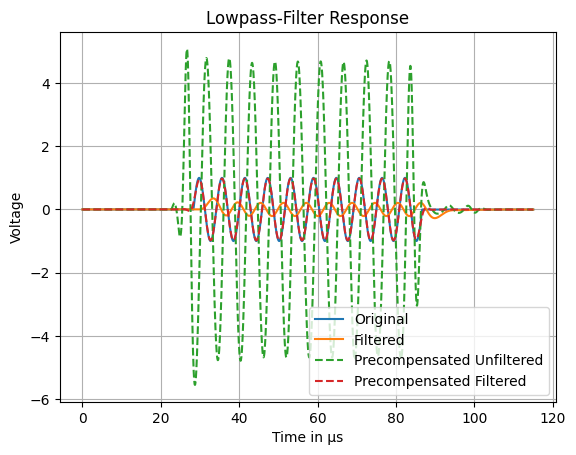

In [ ]:
#Input Variables:
CONSTANT_PADDING = 500
n_s = 1030 #number of time samples (x)
t_s = 300 #number of signal samples (y)
t = 17 #microseconds total
start = -37.7 #Omega's bounds
stop = 25.13

dt = t / t_s #time step
samples = np.arange(n_s + 2*CONSTANT_PADDING) #total time / total samples --> time per sample
time = (samples) * dt

w = np.linspace(start, stop, n_s) #frequency
original = np.sin(w) #Input kind of waveform


original_padded = np.pad(original, (CONSTANT_PADDING, 0), mode='constant', constant_values=0) #pads only on left side
last_index = float(original_padded[-1])
original = np.pad(original_padded, (0, CONSTANT_PADDING), mode='constant', constant_values=last_index)

filtered = FilterSimulation().convolution(original)
shift_f =  np.arange(len(filtered)) * dt # Δt = 17 / 300 ≈ 0.0567 µs
filtered_original = FilterSimulation().interpolation(time, shift_f, filtered)

precompensated = FilterSimulation().precompensation(original, last_index)
FilterSimulation().trimming(precompensated, 400) #trims beginning to 0

precompensated_filtered = FilterSimulation().convolution(precompensated)
shift_p = np.arange(len(precompensated_filtered)) * dt
precompensated_original = FilterSimulation().interpolation(time, shift_p, precompensated_filtered)

shift_p_unfiltered = np.arange(len(precompensated)) * dt
precompensated_unfiltered_interp = FilterSimulation().interpolation(time, shift_p_unfiltered, precompensated)

FilterSimulation().plotter(original, time, filtered_original, precompensated_unfiltered_interp, precompensated_original)